<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Generasi_Teks_dengan_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1: **Import Libraries**
Impor paket utama: Tensorflow (keras) untuk model LSTM, NumPy untuk olah data, Matplotlib untuk visualisasi.

In [ ]:
# Pastikan install dulu jika perlu di Colab
# !pip install tensorflow numpy matplotlib

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import requests

## Cell 2: **Siapkan Dataset Bahasa Indonesia**
Data dummy ini bisa diganti dengan corpus asli. Formatnya satu string besar; bisa ditambah kalimat sebanyak mungkin.


In [ ]:
# Download teks Nietzsche dalam Bahasa Indonesia
url = "https://raw.githubusercontent.com/hyulianton/datakuliah/refs/heads/main/nietzsche-ID.txt"
response = requests.get(url)
text = response.text.lower()

print("Contoh isi data:\n", text[:500])

Contoh isi data:
 prakata

seandainya kebenaran adalah seorang wanita—lantas bagaimana? tidakkah ada alasan untuk mencurigai bahwa semua filsuf, sejauh mereka adalah dogmatis, telah gagal memahami wanita—bahwa keseriusan yang mengerikan dan desakan yang canggung yang biasanya mereka tunjukkan dalam mendekati kebenaran, merupakan metode yang tidak terampil dan tidak pantas untuk memenangkan seorang wanita? tentu saja dia tidak pernah membiarkan dirinya dimenangkan; dan saat ini setiap jenis dogma berdiri dengan 


## Cell 3: **Tokenisasi per Kata**
Tokenizer Keras mengubah kata menjadi angka (integer index). Setiap kata unik punya indeksnya sendiri.

**Tips**:
- oov_token penting agar kata baru tidak jadi “0” (padding).
- Cek x.shape dan y.shape, pastikan tidak nol, dan jumlah sequence signifikan.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="__OOV__")
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])[0]
word_index = tokenizer.word_index
total_words = len(word_index)

window_size = 3  # Turunkan jika dataset kecil

x, y = [], []
for i in range(window_size, len(sequences)):
    x.append(sequences[i-window_size:i])
    y.append(sequences[i])

x = np.array(x)
y = keras.utils.to_categorical(y, num_classes=total_words + 1)

## Cell 4: **Buat Data Sequence untuk Training**
Input berupa window 5 kata, targetnya prediksi kata berikutnya. Output di-one-hot-kan untuk softmax.

In [ ]:
# Sequence input & target (next word prediction, window size n)
window_size = 5

x = []
y = []

for i in range(window_size, len(sequences)):
    x.append(sequences[i-window_size:i])
    y.append(sequences[i])

print(f"Jumlah sequence training: {len(x)}")
print("Contoh x:", x[:2])
print("Contoh target y:", y[:2])

# Ubah ke bentuk array dan one-hot encoding target
x = np.array(x)
y = keras.utils.to_categorical(y, num_classes=total_words + 1)
print("Shape input x:", x.shape)
print("Shape output y:", y.shape)

Jumlah sequence training: 415
Contoh x: [[66, 34, 67, 35, 36], [34, 67, 35, 36, 37]]
Contoh target y: [37, 68]
Shape input x: (415, 5)
Shape output y: (415, 260)


## Cell 5: **Bangun Model LSTM untuk Text Generation**
Model menerima window kata, meng-embed, lewat LSTM, lalu dense output untuk prediksi kata berikutnya.

In [ ]:
model = keras.Sequential([
    layers.Embedding(input_dim=total_words + 1, output_dim=32, input_length=window_size),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(32, activation="relu"),
    layers.Dense(total_words + 1, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Cell 6: **Train Model & Simpan History**
Proses training menggunakan data sequence yang kita buat. Split 10% untuk validasi.


In [ ]:
history = model.fit(x, y, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0190 - loss: 5.5601 - val_accuracy: 0.0602 - val_loss: 5.5613
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0509 - loss: 5.5523 - val_accuracy: 0.0482 - val_loss: 5.5648
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0652 - loss: 5.5428 - val_accuracy: 0.0482 - val_loss: 5.5706
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0611 - loss: 5.5237 - val_accuracy: 0.0482 - val_loss: 5.5835
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0539 - loss: 5.4891 - val_accuracy: 0.0482 - val_loss: 5.6192
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0733 - loss: 5.3903 - val_accuracy: 0.0482 - val_loss: 5.7572
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0466 - loss: 5.2139 - val_accuracy: 0.0482 - val_loss: 6.2261
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0575 - loss: 5.0982 - val_accuracy: 0.

## Cell 7: **Visualisasi Training Loss & Accuracy**
Grafik akurasi & loss supaya bisa dipantau proses learningnya.

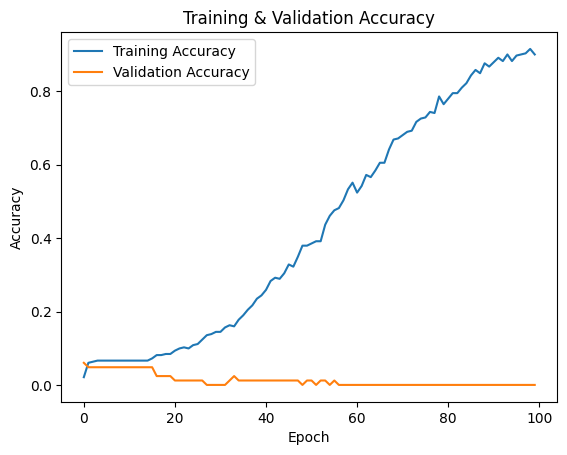

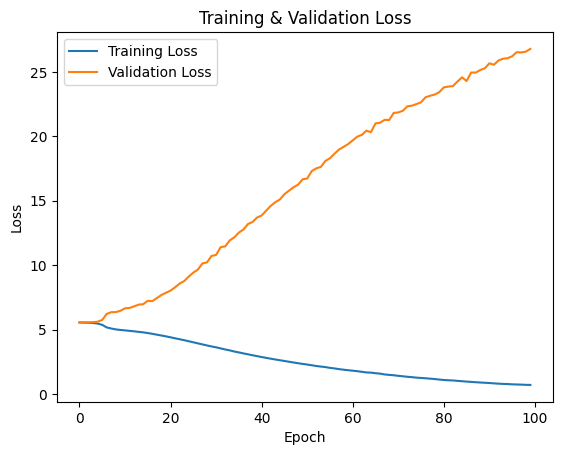

In [ ]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

## Cell 8: **Helper Fungsi untuk Generate Text (per kata)**
Fungsi ini menerima seed text, lalu generate kata demi kata. Setiap kali, prediksi kata berikutnya, dan seed dilengkapi.

In [ ]:
def generate_text(seed_text, next_words=20):
    for _ in range(next_words):
        # Tokenisasi input
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-window_size:]  # window terakhir

        # Padding jika word < window_size
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list],
                                                                   maxlen=window_size)
        # Prediksi
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_id = np.argmax(predicted_probs)
        predicted_word = ''
        for word, idx in word_index.items():
            if idx == predicted_id:
                predicted_word = word
                break
        seed_text += ' ' + predicted_word
    return seed_text

seed = "pendidikan adalah kunci"
print("Hasil generate:")
print(generate_text(seed, next_words=15))

Hasil generate:
pendidikan adalah kunci dogmatis tidakkah ada wanita—lantas untuk untuk bahwa untuk absolut yang yang telah runtuh santo para


## Ringkasan:

- Data: Dummy corpus Bahasa Indonesia, token per kata (bisa ganti dataset lebih besar sesuai kebutuhan).
- Tokenisasi: **Per kata** menggunakan Keras Tokenizer.
- Training: Prediksi kata berikutnya berdasarkan window kata sebelumnya.
- Visualisasi: Akurasi dan loss selama epoch.
- Generasi: Model menerima seed text, dan model melanjutkan satu per satu kata hingga jumlah yang diinginkan.